Обучение определению масштаба снимка на основе энкодера обученной ранее Unet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# =========================
# 0) Setup + deps
# =========================

GSD0_M_PER_PX = 0.30  # базовый GSD твоего тренировочного датасета (м/пикс)

from google.colab import drive
drive.mount('/content/drive')

!pip -q install gdown rasterio tifffile

import os
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import rasterio
from rasterio.windows import Window

import matplotlib.pyplot as plt

# --- reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
device: cuda


In [3]:
# =========================
# 1) Download + unzip
# =========================

GDRIVE_URL = "https://drive.google.com/file/d/1f2pChGHdZ24yb-CFrAAbF8KbS3Ix35Du/view?"
ZIP_ON_DRIVE = "/content/drive/MyDrive/dataset.zip"
OUT_ZIP = "/content/dataset.zip"
OUT_DIR = "/content/dataset"

# !gdown --fuzzy "{GDRIVE_URL}" -O "{OUT_ZIP}"
!cp -v "{ZIP_ON_DRIVE}" "{OUT_ZIP}"
!mkdir -p "{OUT_DIR}"
!unzip -q "{OUT_ZIP}" -d "{OUT_DIR}"
print("dataset dir:", OUT_DIR)

'/content/drive/MyDrive/dataset.zip' -> '/content/dataset.zip'
dataset dir: /content/dataset


In [20]:
# =========================
# 2) Dataset for GSD regression + FILTER EMPTY (must contain buildings)
# - image:  root/images/*.tif
# - mask:   /content/dataset/gt/*.tif   (same filename as image)
# - rejects crops with no buildings (mask window sum == 0)
# =========================

import os, random, math
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, get_worker_info

import rasterio
from rasterio.windows import Window

IMG_EXTS = {".tif"}


def list_imgs_simple(root: str) -> List[str]:
    img_dir = os.path.join(root, "images")
    imgs = []
    for fn in sorted(os.listdir(img_dir)):
        if os.path.splitext(fn.lower())[1] not in IMG_EXTS:
            continue
        imgs.append(os.path.join(img_dir, fn))
    if not imgs:
        raise RuntimeError(f"No images found in: {img_dir}")
    return imgs


def split_by_scene(imgs, val_ratio=0.15, seed=42):
    rng = random.Random(seed)
    idxs = list(range(len(imgs)))
    rng.shuffle(idxs)
    n_val = max(1, int(len(imgs) * val_ratio))
    val = set(idxs[:n_val])
    train_imgs = [p for i, p in enumerate(idxs) if i not in val]  # NOTE: will be overwritten below
    # fix: use original paths, not idxs
    train_imgs = [p for i, p in enumerate(imgs) if i not in val]
    val_imgs   = [p for i, p in enumerate(imgs) if i in val]
    return train_imgs, val_imgs


def to_float01_hwc(img_hwc: np.ndarray) -> np.ndarray:
    if img_hwc.dtype == np.uint8:
        return img_hwc.astype(np.float32) / 255.0
    if img_hwc.dtype == np.uint16:
        return img_hwc.astype(np.float32) / 65535.0
    img = img_hwc.astype(np.float32)
    mx = np.nanmax(img)
    if mx > 1.5:
        img = img / (mx + 1e-6)
    return img


@dataclass
class CropConfig:
    patch_size: int = 256

    # zoom range z: gsd = gsd0 / z
    scale_jitter: Optional[Tuple[float, float]] = (0.25, 1.5)

    # how to sample z
    scale_log_uniform: bool = True
    scale_power: float = 1.0

    augment: bool = True

    # photometric / anti-cheat (only when augment=True)
    color_p: float = 0.85
    brightness: float = 0.12
    contrast: float = 0.12
    saturation: float = 0.12
    gamma: Tuple[float, float] = (0.85, 1.15)

    blur_p: float = 0.20
    blur_sigma: Tuple[float, float] = (0.2, 1.0)

    sharpen_p: float = 0.12
    sharpen_amount: Tuple[float, float] = (0.2, 0.6)
    sharpen_sigma: Tuple[float, float] = (0.6, 1.4)

    noise_p: float = 0.30
    noise_std: Tuple[float, float] = (0.0, 0.02)

    jpeg_p: float = 0.30
    jpeg_q: Tuple[int, int] = (32, 128)
    jpeg_downscale: Tuple[float, float] = (0.6, 1.0)

    shade_p: float = 0.20
    shade_strength: Tuple[float, float] = (0.02, 0.10)

    zoom_padding_mode: str = "border"
    resize_mode_choices: Tuple[str, ...] = ("bilinear", "bicubic", "area")
    antialias_p: float = 0.5


# -------------------------
# blur & unsharp
# -------------------------
_GAUSS1D_CACHE = {}

def _gauss1d(k: int, sigma: float, device, dtype):
    key = (k, float(sigma), str(device), str(dtype))
    if key in _GAUSS1D_CACHE:
        return _GAUSS1D_CACHE[key]
    t = torch.arange(k, device=device, dtype=dtype) - (k - 1) / 2
    g = torch.exp(-(t * t) / (2 * sigma * sigma))
    g = g / (g.sum() + 1e-12)
    _GAUSS1D_CACHE[key] = g
    return g

def blur_chw(x: torch.Tensor, sigma: float):
    if sigma <= 0:
        return x
    k = int(max(3, min(21, round(6 * sigma) | 1)))  # odd
    g = _gauss1d(k, sigma, x.device, x.dtype)
    C, H, W = x.shape
    gx = g.view(1, 1, 1, k).repeat(C, 1, 1, 1)
    gy = g.view(1, 1, k, 1).repeat(C, 1, 1, 1)
    xx = x.unsqueeze(0)
    xx = F.conv2d(xx, gx, padding=(0, k//2), groups=C)
    xx = F.conv2d(xx, gy, padding=(k//2, 0), groups=C)
    return xx.squeeze(0)

def unsharp_mask(x: torch.Tensor, sigma: float, amount: float):
    if amount <= 0:
        return x
    blurred = blur_chw(x, sigma)
    return (x + amount * (x - blurred)).clamp(0, 1)

def jpeg_like(x: torch.Tensor, rng, q_levels: int, downscale: float):
    C, H, W = x.shape
    if downscale < 1.0:
        h2 = max(8, int(round(H * downscale)))
        w2 = max(8, int(round(W * downscale)))
        x = F.interpolate(x.unsqueeze(0), size=(h2, w2), mode="area").squeeze(0)
        x = F.interpolate(x.unsqueeze(0), size=(H, W), mode="bilinear", align_corners=False).squeeze(0)
    q = float(q_levels)
    x = torch.round(x * q) / q
    return x.clamp(0, 1)

def photometric_jitter(x: torch.Tensor, rng, cfg: CropConfig):
    if rng.random() >= cfg.color_p:
        return x

    g = rng.uniform(cfg.gamma[0], cfg.gamma[1])
    x = x.clamp(0, 1) ** g

    b = rng.uniform(1 - cfg.brightness, 1 + cfg.brightness)
    c = rng.uniform(1 - cfg.contrast,   1 + cfg.contrast)
    mean = x.mean(dim=(1,2), keepdim=True)
    x = (x - mean) * c + mean
    x = (x * b).clamp(0, 1)

    if x.shape[0] == 3 and cfg.saturation > 0:
        s = rng.uniform(1 - cfg.saturation, 1 + cfg.saturation)
        gray = (0.2989*x[0] + 0.5870*x[1] + 0.1140*x[2]).unsqueeze(0)
        x = (x * s + gray * (1 - s)).clamp(0, 1)

    return x

def add_soft_shade(x: torch.Tensor, rng, cfg: CropConfig):
    if rng.random() >= cfg.shade_p:
        return x
    _, H, W = x.shape
    strength = rng.uniform(cfg.shade_strength[0], cfg.shade_strength[1])
    shade = torch.randn((1, H, W), device=x.device, dtype=x.dtype)
    shade = blur_chw(shade, sigma=rng.uniform(2.0, 6.0))
    shade = (shade - shade.amin()) / (shade.amax() - shade.amin() + 1e-6)
    shade = 1.0 - strength * (shade - 0.5)
    return (x * shade).clamp(0, 1)

def sample_zoom(rng, zmin: float, zmax: float, log_uniform: bool, power: float):
    zmin = float(zmin); zmax = float(zmax)
    if zmin <= 0 or zmax <= 0:
        raise ValueError("scale_jitter zoom bounds must be > 0")

    u = rng.random()
    p = float(power)

    if p != 1.0:
        u = (u**p) / ((u**p) + ((1-u)**p) + 1e-12)

    if log_uniform:
        logz = math.log(zmin) + u * (math.log(zmax) - math.log(zmin))
        return float(math.exp(logz))
    return float(zmin + u * (zmax - zmin))


class SatGSDDataset(Dataset):
    def __init__(
        self,
        root: str,
        split: str = "train",
        val_ratio: float = 0.15,
        seed: int = 42,
        samples_per_epoch: int = 4000,
        crop: CropConfig = CropConfig(),
        gsd0_m_per_px: float = 0.30,

        mask_root: Optional[str] = "/content/dataset/gt",
        require_building: bool = True,
        min_building_px: int = 1,
        max_tries: int = 30,
    ):
        assert split in ("train", "val")
        self.root = root
        self.split = split
        self.samples_per_epoch = int(samples_per_epoch)
        self.crop = crop
        self.gsd0 = float(gsd0_m_per_px)

        self.mask_root = mask_root if mask_root is not None else os.path.join(root, "gt")
        self.require_building = bool(require_building)
        self.min_building_px = int(min_building_px)
        self.max_tries = int(max_tries)

        imgs = list_imgs_simple(root)
        train_imgs, val_imgs = split_by_scene(imgs, val_ratio=val_ratio, seed=seed)
        self.imgs = train_imgs if split == "train" else val_imgs

        self.base_seed = int(seed if split == "val" else seed + 1337)
        self._rng_main = random.Random(self.base_seed)

        self._sizes = {}   # img sizes cache
        self._msizes = {}  # mask sizes cache

    def __len__(self):
        return self.samples_per_epoch if self.split == "train" else max(1, len(self.imgs) * 50)

    def _get_rng(self):
        wi = get_worker_info()
        if wi is None:
            return self._rng_main
        if not hasattr(self, "_rng_worker"):
            s = int(torch.initial_seed() % (2**32))
            self._rng_worker = random.Random(s)
        return self._rng_worker

    def _mask_path(self, img_path: str) -> str:
        return os.path.join(self.mask_root, os.path.basename(img_path))

    def _get_size_cached(self, path: str, cache: dict):
        if path in cache:
            return cache[path]
        with rasterio.open(path) as src:
            cache[path] = (src.width, src.height)
        return cache[path]

    def _augment(self, x: torch.Tensor, rng):
        cfg = self.crop
        if not cfg.augment:
            return x

        if rng.random() < 0.5:
            x = torch.flip(x, dims=[2])
        if rng.random() < 0.5:
            x = torch.flip(x, dims=[1])

        k = rng.randint(0, 3)
        if k:
            x = torch.rot90(x, k, dims=[1, 2])

        x = photometric_jitter(x, rng, cfg)
        x = add_soft_shade(x, rng, cfg)

        if rng.random() < cfg.blur_p:
            sigma = rng.uniform(cfg.blur_sigma[0], cfg.blur_sigma[1])
            x = blur_chw(x, sigma)

        if rng.random() < cfg.sharpen_p:
            sigma = rng.uniform(cfg.sharpen_sigma[0], cfg.sharpen_sigma[1])
            amount = rng.uniform(cfg.sharpen_amount[0], cfg.sharpen_amount[1])
            x = unsharp_mask(x, sigma=sigma, amount=amount)

        if rng.random() < cfg.noise_p:
            std = rng.uniform(cfg.noise_std[0], cfg.noise_std[1])
            if std > 0:
                x = (x + torch.randn_like(x) * std).clamp(0, 1)

        if rng.random() < cfg.jpeg_p:
            q = rng.randint(cfg.jpeg_q[0], cfg.jpeg_q[1])
            ds = rng.uniform(cfg.jpeg_downscale[0], cfg.jpeg_downscale[1])
            x = jpeg_like(x, rng, q_levels=q, downscale=ds)

        return x.clamp(0, 1)

    def _window_has_building(self, mask_path: str, x0: int, y0: int, src_sz: int) -> bool:
        with rasterio.open(mask_path) as ms:
            m = ms.read(1, window=Window(x0, y0, src_sz, src_sz), out_dtype="uint8")
        return int((m > 0).sum()) >= self.min_building_px

    def __getitem__(self, idx):
        rng = self._get_rng()
        cfg = self.crop
        patch = int(cfg.patch_size)

        last = None

        for _ in range(max(1, self.max_tries)):
            if self.split == "train":
                img_path = self.imgs[rng.randrange(len(self.imgs))]
            else:
                img_path = self.imgs[idx % len(self.imgs)]

            mask_path = self._mask_path(img_path)

            W, H = self._get_size_cached(img_path, self._sizes)

            if self.require_building:
                if not os.path.exists(mask_path):
                    raise FileNotFoundError(f"Mask not found: {mask_path}")
                mW, mH = self._get_size_cached(mask_path, self._msizes)
                if (mW != W) or (mH != H):
                    raise RuntimeError(
                        f"Mask size != image size for {os.path.basename(img_path)}: "
                        f"img=({W},{H}) mask=({mW},{mH})"
                    )

            z = 1.0
            if cfg.scale_jitter is not None:
                z = sample_zoom(
                    rng,
                    cfg.scale_jitter[0], cfg.scale_jitter[1],
                    log_uniform=getattr(cfg, "scale_log_uniform", True),
                    power=float(getattr(cfg, "scale_power", 1.0))
                )

            ideal_src = patch / float(z)
            src_sz = int(round(ideal_src))
            src_sz = max(16, min(src_sz, W, H))

            x0 = rng.randint(0, max(0, W - src_sz))
            y0 = rng.randint(0, max(0, H - src_sz))

            if self.require_building:
                if not self._window_has_building(mask_path, x0, y0, src_sz):
                    continue

            last = (img_path, W, H, x0, y0, src_sz, z)
            break

        if last is None:
            img_path = self.imgs[idx % len(self.imgs)]
            W, H = self._get_size_cached(img_path, self._sizes)

            z = 1.0
            if cfg.scale_jitter is not None:
                z = sample_zoom(
                    rng,
                    cfg.scale_jitter[0], cfg.scale_jitter[1],
                    log_uniform=getattr(cfg, "scale_log_uniform", True),
                    power=float(getattr(cfg, "scale_power", 1.0))
                )

            ideal_src = patch / float(z)
            src_sz = int(round(ideal_src))
            src_sz = max(16, min(src_sz, W, H))

            x0 = rng.randint(0, max(0, W - src_sz))
            y0 = rng.randint(0, max(0, H - src_sz))
        else:
            img_path, W, H, x0, y0, src_sz, z = last

        with rasterio.open(img_path) as im:
            bands = [1, 2, 3] if im.count >= 3 else list(range(1, im.count + 1))
            img = im.read(bands, window=Window(x0, y0, src_sz, src_sz))  # CHW

        img_hwc = np.transpose(img, (1, 2, 0))
        img_hwc = to_float01_hwc(img_hwc)
        img_chw = np.transpose(img_hwc, (2, 0, 1))

        if img_chw.shape[0] == 1:
            img_chw = np.repeat(img_chw, 3, axis=0)
        elif img_chw.shape[0] == 2:
            img_chw = np.concatenate([img_chw, img_chw[:1]], axis=0)

        x = torch.from_numpy(img_chw).float()  # [C,src_sz,src_sz]

        if src_sz != patch:
            mode = rng.choice(getattr(cfg, "resize_mode_choices", ("bilinear", "bicubic", "area")))
            if mode == "area":
                x = F.interpolate(x.unsqueeze(0), size=(patch, patch), mode="area").squeeze(0)
            else:
                aa = (rng.random() < float(getattr(cfg, "antialias_p", 0.5)))
                try:
                    x = F.interpolate(
                        x.unsqueeze(0), size=(patch, patch),
                        mode=mode, align_corners=False, antialias=aa
                    ).squeeze(0)
                except TypeError:
                    x = F.interpolate(
                        x.unsqueeze(0), size=(patch, patch),
                        mode=mode, align_corners=False
                    ).squeeze(0)

        x = self._augment(x, rng)

        gsd_patch = self.gsd0 / float(z)
        t = torch.tensor(math.log(gsd_patch + 1e-12), dtype=torch.float32)

        return x, t


In [22]:
# =========================
# 3) Make DataLoaders (GSD regression) — CLEAN + FAST + no comb
# train: augs + continuous scale jitter
# val_loader: continuous scale jitter, NO augs
# =========================

import os, numpy as np, random, torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def worker_init_fn(worker_id):
    torch.set_num_threads(1)
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    seed = 42 + worker_id
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# --- train crop/augs ---
crop_train = CropConfig(
    patch_size=256,
    scale_jitter=(0.25, 1.5),
    scale_log_uniform=True,
    scale_power=1.0,
    augment=True,

    color_p=0.85,
    brightness=0.12,
    contrast=0.12,
    saturation=0.12,
    gamma=(0.85, 1.15),

    blur_p=0.20,
    blur_sigma=(0.2, 1.0),

    sharpen_p=0.12,
    sharpen_amount=(0.2, 0.6),
    sharpen_sigma=(0.6, 1.4),

    noise_p=0.30,
    noise_std=(0.0, 0.02),

    jpeg_p=0.30,
    jpeg_q=(32, 128),
    jpeg_downscale=(0.6, 1.0),

    shade_p=0.20,
    shade_strength=(0.02, 0.10),

    zoom_padding_mode="border",
)

# --- val: scale jitter, NO augs ---
crop_val = CropConfig(
    patch_size=256,
    scale_jitter=(0.25, 1.5),
    scale_log_uniform=True,
    scale_power=1.0,
    augment=False,
    zoom_padding_mode="border",
)

train_ds = SatGSDDataset(
    OUT_DIR, split="train", val_ratio=0.15, seed=42,
    samples_per_epoch=4000, crop=crop_train,
    gsd0_m_per_px=GSD0_M_PER_PX
)

val_ds = SatGSDDataset(
    OUT_DIR, split="val", val_ratio=0.15, seed=42,
    samples_per_epoch=1200, crop=crop_val,
    gsd0_m_per_px=GSD0_M_PER_PX
)

NUM_WORKERS = 2  # если всё стабильно, можно 4

train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(NUM_WORKERS > 0),
    worker_init_fn=worker_init_fn,
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)

val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(NUM_WORKERS > 0),
    worker_init_fn=worker_init_fn,
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)





GSD stats (m/px):
  min   : 0.20073112845420837
  p05   : 0.2203330248594284
  median: 0.5397031307220459
  p95   : 1.1090716123580933
  max   : 1.1998014450073242


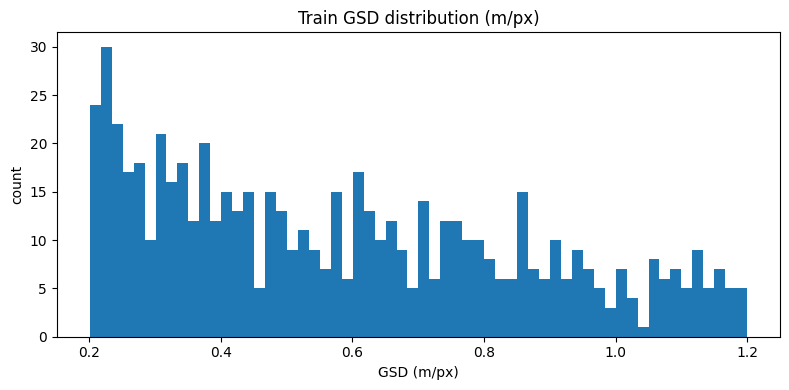

GSD stats (m/px):
  min   : 0.2001451700925827
  p05   : 0.22040575742721558
  median: 0.5398213267326355
  p95   : 1.097712516784668
  max   : 1.195374608039856


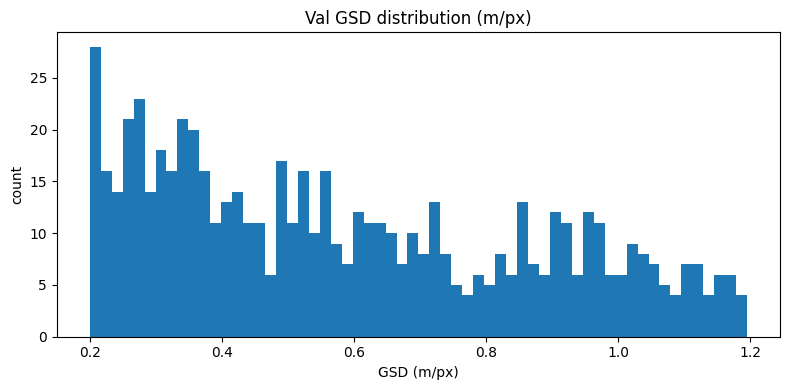

In [23]:
# =========================
# Distribution of GSD in train samples
# =========================

def quick_gsd_hist(loader, n_batches=80, bins=50, title="GSD distribution"):
    g = []
    for i, (_, tb) in enumerate(loader):
        if i >= n_batches:
            break
        g.append(torch.exp(tb).cpu().numpy())
    g = np.concatenate(g)

    print("GSD stats (m/px):")
    print("  min   :", float(np.min(g)))
    print("  p05   :", float(np.percentile(g, 5)))
    print("  median:", float(np.percentile(g, 50)))
    print("  p95   :", float(np.percentile(g, 95)))
    print("  max   :", float(np.max(g)))

    plt.figure(figsize=(8,4))
    plt.hist(g, bins=bins)
    plt.title(title)
    plt.xlabel("GSD (m/px)")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

quick_gsd_hist(train_loader, n_batches=80, bins=60, title="Train GSD distribution (m/px)")
quick_gsd_hist(val_loader,   n_batches=80, bins=60, title="Val GSD distribution (m/px)")

1) Модель + loss + метрики

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# =========================
# ResNet50 encoder -> GSD regressor
# Возвращает dict {"t": pred_log_gsd}, чтобы было удобно расширять
# =========================

class ResNet50GSDRegressor(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.encoder = resnet50(weights=None)
        self.encoder.fc = nn.Identity()  # важно

        # те же блоки, что и в U-Net
        self.enc0 = nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu)  # /2, 64
        self.pool = self.encoder.maxpool                                                    # /4
        self.enc1 = self.encoder.layer1                                                      # /4, 256
        self.enc2 = self.encoder.layer2                                                      # /8, 512
        self.enc3 = self.encoder.layer3                                                      # /16, 1024
        self.enc4 = self.encoder.layer4                                                      # /32, 2048

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),                 # 2048
            nn.Linear(2048, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),            # pred log(GSD)
        )

    def forward(self, x):
        x0 = self.enc0(x)
        x1 = self.enc1(self.pool(x0))
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)

        z = self.gap(x4)                  # [B,2048,1,1]
        t = self.head(z).squeeze(1)       # [B]
        return {"t": t}


# --- Model ---
model = ResNet50GSDRegressor(dropout=0.2).to(device)

# =========================
# Load encoder weights from your UNet checkpoint (optional but recommended)
# =========================
import os

UNET_LAST_PATH = "/content/drive/MyDrive/Models/last_unet.pt"   # или best_unet.pt

def load_encoder_from_unet_ckpt(gsd_model, unet_ckpt_path):
    ckpt = torch.load(unet_ckpt_path, map_location="cpu")
    sd = ckpt["model_state_dict"] if (isinstance(ckpt, dict) and "model_state_dict" in ckpt) else ckpt

    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}

    # пробуем вытащить encoder.* (как в твоём UNet)
    enc_sd = {k.replace("encoder.", "", 1): v for k, v in sd.items() if k.startswith("encoder.")}

    # fallback: если вдруг ключи были model.encoder.*
    if len(enc_sd) == 0:
        enc_sd = {k.replace("model.encoder.", "", 1): v for k, v in sd.items() if k.startswith("model.encoder.")}

    if len(enc_sd) == 0:
        raise RuntimeError("Не найдено encoder.* ключей в чекпоинте. Провериль названия ключей в state_dict.")

    missing, unexpected = gsd_model.encoder.load_state_dict(enc_sd, strict=False)
    print("✅ Loaded encoder from UNet ckpt:", unet_ckpt_path)
    print("   extracted encoder keys:", len(enc_sd))
    print("   missing:", len(missing), "| unexpected:", len(unexpected))
    if missing:
        print("   missing examples:", missing[:10])
    if unexpected:
        print("   unexpected examples:", unexpected[:10])

if os.path.exists(UNET_LAST_PATH):
    load_encoder_from_unet_ckpt(model, UNET_LAST_PATH)
else:
    print("⚠️ UNet checkpoint not found, training encoder from scratch:", UNET_LAST_PATH)

# =========================
# Loss + metrics (регрессия log(GSD))
# =========================

# Huber (SmoothL1) обычно устойчивее MSE, особенно на широком диапазоне масштабов
loss_reg = nn.SmoothL1Loss(beta=0.05)

def loss_fn(pred_t, target_t):
    # pred_t: [B], target_t: [B]
    return loss_reg(pred_t, target_t)

@torch.no_grad()
def metrics_reg(pred_t, target_t):
    """
    Возвращаем метрики уже в метрах/пикс:
      MAE, RMSE, MAPE (%)
    """
    gsd_hat = torch.exp(pred_t)
    gsd_true = torch.exp(target_t)

    mae = (gsd_hat - gsd_true).abs().mean().item()
    rmse = torch.sqrt(((gsd_hat - gsd_true) ** 2).mean()).item()
    mape = (((gsd_hat - gsd_true).abs() / (gsd_true + 1e-6)).mean().item()) * 100.0
    return mae, rmse, mape

device: cuda
✅ Loaded encoder from UNet ckpt: /content/drive/MyDrive/Models/last_unet.pt
   extracted encoder keys: 318
   missing: 0 | unexpected: 0


2) Optimizer + train/eval для GSD regression

In [8]:
import math
import torch
from torch.amp import autocast                 # новый autocast (рекомендуется)
from torch.cuda.amp import GradScaler

# =========================
# Optimizer for GSD regression
# encoder: маленький lr (чтобы не ломать признаки)
# head: побольше lr
# =========================

encoder_params = list(model.encoder.parameters())
head_params    = list(model.head.parameters())

optimizer = torch.optim.AdamW(
    [
        {"params": encoder_params, "lr": 3e-6},
        {"params": head_params,    "lr": 3e-5},
    ],
    weight_decay=1e-4
)

scaler = GradScaler(enabled=(device.type == "cuda"))

# Настройки:
BATCH = 8
ACCUM = 4
MAX_GRAD_NORM = 1.0


def train_one_epoch(model, loader):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    running_loss = 0.0
    num_batches = 0
    accum_count = 0

    for step, (x, t) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        t = t.to(device, non_blocking=True)  # t = log(GSD), [B]

        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            pred_t = model(x)["t"]                 # [B]
            loss = loss_fn(pred_t, t)              # scalar

        # аккумулируем градиенты
        loss_to_backprop = loss / ACCUM
        scaler.scale(loss_to_backprop).backward()

        accum_count += 1
        running_loss += float(loss.item())
        num_batches += 1

        if accum_count == ACCUM:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

    # хвост (обычно не нужен, если len(loader) кратен ACCUM, но пусть будет безопасно)
    if accum_count != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    return running_loss / max(1, num_batches)


@torch.no_grad()
def evaluate(model, loader, max_batches=200):
    """
    Возвращает:
      mean_loss_per_batch, MAE(m/px), RMSE(m/px), MAPE(%)
    MAE/RMSE/MAPE считаются по всем сэмплам (sample-weighted), а не batch-averaged.
    """
    model.eval()

    total_loss = 0.0
    n_batches = 0
    n_samples = 0

    sum_abs = 0.0
    sum_sq  = 0.0
    sum_ape = 0.0

    for b, (x, t_true) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        t_true = t_true.to(device, non_blocking=True)

        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            t_pred = model(x)["t"]
            loss = loss_fn(t_pred, t_true)

        # метрики в м/пикс
        t_pred_c = torch.clamp(t_pred, -10, 10)
        t_true_c = torch.clamp(t_true, -10, 10)

        g_pred = torch.exp(t_pred_c)
        g_true = torch.exp(t_true_c)

        err = g_pred - g_true
        abs_err = err.abs()

        bs = x.size(0)

        total_loss += float(loss.item())
        n_batches += 1
        n_samples += bs

        sum_abs += float(abs_err.sum().item())
        sum_sq  += float((err * err).sum().item())
        sum_ape += float((abs_err / (g_true + 1e-6)).sum().item())

    if n_samples == 0:
        return 0.0, 0.0, 0.0, 0.0

    mae = sum_abs / n_samples
    rmse = math.sqrt(sum_sq / n_samples)
    mape = (sum_ape / n_samples) * 100.0

    return (total_loss / max(1, n_batches), mae, rmse, mape)

/tmp/ipython-input-2949066813.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


3) Запуск обучения

In [ ]:
# =========================
# Train GSD regressor (ResNet50 encoder) + checkpointing
# - train: train_loader
# - val:   val_loader
# Best is chosen by MAE on val_loader
# =========================

import os
import math
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler

GSD_BEST_PATH = "/content/drive/MyDrive/Models/best_gsd.pt"
GSD_LAST_PATH = "/content/drive/MyDrive/Models/last_gsd.pt"

# -------------------------
# Choose resume source
# -------------------------
RESUME_FROM = "last"   # <-- выбор чекпоинта
assert RESUME_FROM in ("last", "best")
resume_path = GSD_LAST_PATH if RESUME_FROM == "last" else GSD_BEST_PATH

# -------------------------
# Optimizer rebuild
# -------------------------
def rebuild_optimizer_for_gsd(model, weight_decay=1e-4, lr_enc=3e-6, lr_head=3e-5):
    return torch.optim.AdamW(
        [
            {"params": list(model.encoder.parameters()), "lr": lr_enc},
            {"params": list(model.head.parameters()),    "lr": lr_head},
        ],
        weight_decay=weight_decay
    )

# -------------------------
# Train / Eval (regression)
# -------------------------
ACCUM = 4
MAX_GRAD_NORM = 1.0
EVAL_MAX_BATCHES = 200  # None -> весь вал

def train_one_epoch_reg(model, loader, optimizer, scaler, accum=1, max_grad_norm=1.0):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    running_loss = 0.0
    n_batches = 0
    accum_count = 0

    for (x, t_true) in loader:
        x = x.to(device, non_blocking=True)
        t_true = t_true.to(device, non_blocking=True)

        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            t_pred = model(x)["t"]              # [B]
            loss = loss_fn(t_pred, t_true)      # log-space regression

        scaler.scale(loss / accum).backward()

        running_loss += float(loss.item())
        n_batches += 1
        accum_count += 1

        if accum_count == accum:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            accum_count = 0

    # хвост
    if accum_count != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    return running_loss / max(1, n_batches)

@torch.no_grad()
def evaluate_reg(model, loader, max_batches=200):
    """
    Возвращает:
      mean_loss_per_batch, MAE(m/px), RMSE(m/px), MAPE(%)
    Метрики считаем sample-weighted (важно при последнем неполном батче).
    """
    model.eval()

    total_loss = 0.0
    n_batches = 0
    n_samples = 0

    sum_abs = 0.0
    sum_sq  = 0.0
    sum_ape = 0.0

    for b, (x, t_true) in enumerate(loader):
        if (max_batches is not None) and (b >= max_batches):
            break

        x = x.to(device, non_blocking=True)
        t_true = t_true.to(device, non_blocking=True)

        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            t_pred = model(x)["t"]
            loss = loss_fn(t_pred, t_true)

        # метрики уже в GSD (м/пикс)
        g_pred = torch.exp(torch.clamp(t_pred, -10, 10))
        g_true = torch.exp(torch.clamp(t_true, -10, 10))

        err = g_pred - g_true
        abs_err = err.abs()

        bs = int(x.size(0))
        total_loss += float(loss.item())
        n_batches += 1
        n_samples += bs

        sum_abs += float(abs_err.sum().item())
        sum_sq  += float((err * err).sum().item())
        sum_ape += float((abs_err / (g_true + 1e-6)).sum().item())

    if n_samples == 0:
        return 0.0, 0.0, 0.0, 0.0

    mae  = sum_abs / n_samples
    rmse = math.sqrt(sum_sq / n_samples)
    mape = (sum_ape / n_samples) * 100.0

    return (total_loss / max(1, n_batches), mae, rmse, mape)

# -------------------------
# Resume
# -------------------------
start_epoch = 1
best_mae = float("inf")
best_epoch = 0

optimizer = rebuild_optimizer_for_gsd(model, weight_decay=1e-4, lr_enc=3e-6, lr_head=3e-5)
scaler = GradScaler(enabled=(device.type == "cuda"))

if os.path.exists(resume_path):
    ckpt = torch.load(resume_path, map_location="cpu")
    sd = ckpt.get("model_state_dict", ckpt)
    model.load_state_dict(sd, strict=True)
    model.to(device)

    best_mae = ckpt.get("best_mae", ckpt.get("best_mae_jitter", best_mae))
    best_epoch = ckpt.get("best_epoch", ckpt.get("epoch", 0))
    start_epoch = ckpt.get("epoch", 0) + 1

    if "optimizer_state_dict" in ckpt:
        try:
            optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        except Exception as e:
            print("⚠️ Optimizer state mismatch -> fresh optimizer (ok).", repr(e))

    if "scaler_state_dict" in ckpt:
        try:
            scaler.load_state_dict(ckpt["scaler_state_dict"])
        except Exception as e:
            print("⚠️ Scaler state not loaded (ok).", repr(e))

    print(f"✅ Resumed from {resume_path} (epoch={start_epoch-1}, best_mae={best_mae:.6f})")
else:
    model.to(device)
    print(f"Starting training (resume_path not found: {resume_path}).")

# -------------------------
# Train loop
# -------------------------
num_more_epochs = 10

for epoch in range(start_epoch, start_epoch + num_more_epochs):
    tr_loss = train_one_epoch_reg(
        model, train_loader, optimizer, scaler,
        accum=ACCUM, max_grad_norm=MAX_GRAD_NORM
    )

    val_loss, mae, rmse, mape = evaluate_reg(
        model, val_loader, max_batches=EVAL_MAX_BATCHES
    )

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | "
        f"MAE={mae:.5f} m/px | RMSE={rmse:.5f} | MAPE={mape:.2f}%"
    )

    # best by MAE
    if mae < best_mae:
        best_mae = mae
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "best_epoch": best_epoch,
            "best_mae": best_mae,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scaler_state_dict": scaler.state_dict(),
        }, GSD_BEST_PATH)
        print(f"  ✅ Saved BEST: epoch={epoch}, MAE={best_mae:.6f} -> {GSD_BEST_PATH}")

    # last
    torch.save({
        "epoch": epoch,
        "best_epoch": best_epoch,
        "best_mae": best_mae,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
    }, GSD_LAST_PATH)

/tmp/ipython-input-3446028442.py:144: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


✅ Resumed from /content/drive/MyDrive/Models/best_gsd.pt (epoch=40, best_mae=0.085420)
Epoch 41 | train_loss=0.1575 | val_loss=0.1348 | MAE=0.08788 m/px | RMSE=0.12235 | MAPE=16.04%


Проверка

In [16]:
# =========================
# Check GSD regressor: interactive preview + error distribution
# =========================

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from contextlib import nullcontext
from torch.cuda.amp import autocast as cuda_autocast

# --- Paths ---
BEST_PATH = "/content/drive/MyDrive/Models/best_gsd.pt"
LAST_PATH = "/content/drive/MyDrive/Models/last_gsd.pt"

# --- UI state ---
_state = {
    "current_ckpt": None,
    "val_iter": None,
    "n_show": 6,          # сколько картинок показывать за раз
    "max_batches": 200,   # сколько батчей прогонять для гистограммы
}

def _load_checkpoint_into_model(which: str):
    assert which in ("best", "last")
    path = BEST_PATH if which == "best" else LAST_PATH
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")

    ckpt = torch.load(path, map_location="cpu")
    model.load_state_dict(ckpt["model_state_dict"], strict=True)
    model.to(device)

    _state["current_ckpt"] = {
        "which": which,
        "path": path,
        "epoch": ckpt.get("epoch"),
        "best_mae": ckpt.get("best_mae"),
        "best_epoch": ckpt.get("best_epoch"),
    }

    _state["val_iter"] = iter(val_loader)
    return _state["current_ckpt"]

@torch.no_grad()
def _predict_batch(xb, tb):
    """
    xb: [B,C,H,W], tb: [B] log(GSD)
    returns: gsd_true [B], gsd_pred [B]
    """
    xb = xb.to(device, non_blocking=True)
    tb = tb.to(device, non_blocking=True)

    amp_ctx = cuda_autocast(enabled=(device.type == "cuda")) if device.type == "cuda" else nullcontext()
    with amp_ctx:
        pred_t = model(xb)["t"]                 # [B]
    gsd_pred = torch.exp(pred_t).detach()
    gsd_true = torch.exp(tb).detach()
    return gsd_true, gsd_pred

def _fmt_row(g_true, g_pred):
    err = (g_pred - g_true)
    mae = abs(err)
    ape = mae / (g_true + 1e-6) * 100.0
    return f"true={g_true:.4f} m/px | pred={g_pred:.4f} m/px | abs_err={mae:.4f} | rel_err={ape:.2f}%"

@torch.no_grad()
def _show_next_batch(n=6):
    if _state["val_iter"] is None:
        _state["val_iter"] = iter(val_loader)

    try:
        xb, tb = next(_state["val_iter"])
    except StopIteration:
        _state["val_iter"] = iter(val_loader)
        xb, tb = next(_state["val_iter"])

    gsd_true, gsd_pred = _predict_batch(xb, tb)

    # на CPU для визуализации
    xb_np = xb[:n].permute(0, 2, 3, 1).cpu().numpy()
    gsd_true = gsd_true[:n].cpu().numpy()
    gsd_pred = gsd_pred[:n].cpu().numpy()

    ck = _state["current_ckpt"]
    if ck is not None:
        print(f"Checkpoint: {ck['which']} | epoch={ck['epoch']} | best_mae={ck.get('best_mae')} | best_epoch={ck.get('best_epoch')}")
    else:
        print("Checkpoint: (not loaded)")
    print("-" * 90)

    # grid
    cols = 3
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(14, 4.6 * rows))

    for i in range(n):
        img = np.clip(xb_np[i], 0, 1)
        gt = float(gsd_true[i])
        pr = float(gsd_pred[i])

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(_fmt_row(gt, pr), fontsize=10)

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def _error_hist(max_batches=200, bins=40):
    """
    Строит распределение ошибок по части/всей val выборке:
    - abs error в м/пикс
    - rel error в %
    Также печатает summary.
    """
    model.eval()

    abs_errs = []
    rel_errs = []
    trues = []
    preds = []

    for b, (xb, tb) in enumerate(val_loader):
        if max_batches is not None and b >= max_batches:
            break

        gsd_true, gsd_pred = _predict_batch(xb, tb)

        e_abs = (gsd_pred - gsd_true).abs()
        e_rel = e_abs / (gsd_true + 1e-6) * 100.0

        abs_errs.append(e_abs.cpu().numpy())
        rel_errs.append(e_rel.cpu().numpy())
        trues.append(gsd_true.cpu().numpy())
        preds.append(gsd_pred.cpu().numpy())

    abs_errs = np.concatenate(abs_errs)
    rel_errs = np.concatenate(rel_errs)
    trues = np.concatenate(trues)
    preds = np.concatenate(preds)

    # summary
    mae = abs_errs.mean()
    rmse = np.sqrt(((preds - trues) ** 2).mean())
    mape = rel_errs.mean()

    p50 = np.percentile(abs_errs, 50)
    p75 = np.percentile(abs_errs, 75)
    p90 = np.percentile(abs_errs, 90)
    p95 = np.percentile(abs_errs, 95)

    print(f"Eval on ~{len(abs_errs)} samples (max_batches={max_batches})")
    print(f"MAE={mae:.6f} m/px | RMSE={rmse:.6f} m/px | MAPE={mape:.3f}%")
    print(f"Abs error percentiles: p50={p50:.6f}, p75={p75:.6f}, p90={p90:.6f}, p95={p95:.6f} (m/px)")
    print("-" * 90)

    # histograms
    plt.figure(figsize=(14, 4.5))

    plt.subplot(1, 2, 1)
    plt.hist(abs_errs, bins=bins)
    plt.title("Absolute error distribution (m/px)")
    plt.xlabel("|pred - true| (m/px)")
    plt.ylabel("count")

    plt.subplot(1, 2, 2)
    plt.hist(rel_errs, bins=bins)
    plt.title("Relative error distribution (%)")
    plt.xlabel("|pred - true| / true (%)")
    plt.ylabel("count")

    plt.tight_layout()
    plt.show()

    # удобные "как часто ошибка меньше порога"
    for thr in [0.01, 0.02, 0.03, 0.05]:
        frac = (abs_errs <= thr).mean() * 100
        print(f"abs_err <= {thr:.2f} m/px: {frac:.1f}% of samples")

# --- Widgets ---
dd = widgets.Dropdown(
    options=[("best", "best"), ("last", "last")],
    value="best",
    description="Checkpoint:",
    layout=widgets.Layout(width="260px")
)

n_w = widgets.IntSlider(
    value=_state["n_show"], min=1, max=12, step=1,
    description="show:",
    continuous_update=False,
    layout=widgets.Layout(width="360px")
)

mb_w = widgets.IntSlider(
    value=_state["max_batches"], min=10, max=400, step=10,
    description="max_batches:",
    continuous_update=False,
    layout=widgets.Layout(width="420px")
)

btn_next = widgets.Button(
    description="Показать другие",
    button_style="primary",
    layout=widgets.Layout(width="220px")
)

btn_hist = widgets.Button(
    description="Гистограмма ошибок",
    button_style="info",
    layout=widgets.Layout(width="220px")
)

out = widgets.Output()

def _render_initial():
    out.clear_output(wait=True)
    with out:
        _load_checkpoint_into_model(dd.value)
        _state["n_show"] = int(n_w.value)
        _state["max_batches"] = int(mb_w.value)
        _show_next_batch(n=_state["n_show"])

def _on_dd_change(change):
    if change["name"] == "value":
        _render_initial()

def _on_btn_next(_):
    out.clear_output(wait=True)
    with out:
        _show_next_batch(n=int(n_w.value))

def _on_btn_hist(_):
    out.clear_output(wait=True)
    with out:
        _error_hist(max_batches=int(mb_w.value), bins=40)

dd.observe(_on_dd_change, names="value")
btn_next.on_click(_on_btn_next)
btn_hist.on_click(_on_btn_hist)

ui = widgets.VBox([
    widgets.HBox([dd, n_w, btn_next, btn_hist]),
    mb_w
])

display(ui, out)
_render_initial()

Output()

In [17]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from contextlib import nullcontext
from torch.cuda.amp import autocast as cuda_autocast

# --- Paths ---
BEST_PATH = "/content/drive/MyDrive/Models/best_gsd.pt"
LAST_PATH = "/content/drive/MyDrive/Models/last_gsd.pt"

# --- UI state ---
_state = {
    "current_ckpt": None,
}

def _load_checkpoint_into_model(which: str):
    assert which in ("best", "last")
    path = BEST_PATH if which == "best" else LAST_PATH
    if not os.path.exists(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")

    ckpt = torch.load(path, map_location="cpu")
    sd = ckpt["model_state_dict"] if (isinstance(ckpt, dict) and "model_state_dict" in ckpt) else ckpt
    model.load_state_dict(sd, strict=True)

    _state["current_ckpt"] = {
        "which": which,
        "path": path,
        "epoch": ckpt.get("epoch"),
        "best_mae": ckpt.get("best_mae", ckpt.get("best_metric", None)),
    }
    return _state["current_ckpt"]

@torch.no_grad()
def eval_gsd_with_error_hist(
    model,
    loader,
    max_batches=None,
    hist_bins=50,
    gsd_bins=(0.20, 0.30, 0.50, 0.80, 1.20, 2.00),
    scatter_max=4000,
):
    model.eval()

    pred_log_list = []
    true_log_list = []

    amp_ctx = cuda_autocast(enabled=(device.type == "cuda")) if device.type == "cuda" else nullcontext()

    for b, (x, t_true) in enumerate(loader):
        if max_batches is not None and b >= max_batches:
            break

        x = x.to(device, non_blocking=True)
        t_true = t_true.to(device, non_blocking=True)

        with amp_ctx:
            out = model(x)
            t_pred = out["t"]  # [B]

        pred_log_list.append(t_pred.detach().float().cpu())
        true_log_list.append(t_true.detach().float().cpu())

    pred_log = torch.cat(pred_log_list, dim=0)
    true_log = torch.cat(true_log_list, dim=0)

    gsd_hat  = torch.exp(pred_log)
    gsd_true = torch.exp(true_log)

    abs_err = (gsd_hat - gsd_true).abs()
    rel_err = abs_err / (gsd_true + 1e-6)

    mae  = abs_err.mean().item()
    rmse = torch.sqrt(((gsd_hat - gsd_true) ** 2).mean()).item()
    mape = (rel_err.mean().item() * 100.0)

    # Ещё полезная метрика: ошибка в log-пространстве => мультипликативная
    log_mae = (pred_log - true_log).abs().mean().item()
    # Примерная "типичная" мультипликативная ошибка:
    # exp(log_mae) - 1 ~ средняя относительная ошибка в множителе
    mult = (np.exp(log_mae) - 1.0) * 100.0

    # --- print summary ---
    print("=== GSD regression eval ===")
    ck = _state.get("current_ckpt", None)
    if ck:
        print(f"Checkpoint: {ck['which']} | epoch={ck['epoch']} | best_mae={ck['best_mae']}")
    print(f"N={len(gsd_true)}")
    print(f"MAE :  {mae:.5f} m/px")
    print(f"RMSE:  {rmse:.5f} m/px")
    print(f"MAPE:  {mape:.2f} %")
    print(f"log-MAE: {log_mae:.5f} (=> типичная ошибка ~{mult:.2f}% в множителе)")

    # --- bins table ---
    if gsd_bins is not None and len(gsd_bins) >= 2:
        print("\n=== By True GSD bins (m/px) ===")
        print("   lo     hi       N     MAE     RMSE    MAPE%")
        bins = list(gsd_bins)
        for i in range(len(bins) - 1):
            lo, hi = bins[i], bins[i+1]
            m = (gsd_true >= lo) & (gsd_true < hi)
            n = int(m.sum().item())
            if n == 0:
                print(f"{lo:6.2f} {hi:6.2f}  {n:6d}    -       -       -")
                continue
            ae = abs_err[m]
            re = rel_err[m]
            rmse_b = torch.sqrt(((gsd_hat[m] - gsd_true[m]) ** 2).mean()).item()
            print(f"{lo:6.2f} {hi:6.2f}  {n:6d}  {ae.mean().item():7.4f}  {rmse_b:7.4f}  {re.mean().item()*100:7.2f}")

    # --- plots ---
    plt.figure(figsize=(9, 4))
    plt.hist(abs_err.numpy(), bins=hist_bins)
    plt.title("Absolute error distribution |GSD_hat - GSD_true| (m/px)")
    plt.xlabel("Absolute error (m/px)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4))
    plt.hist((rel_err.numpy() * 100.0), bins=hist_bins)
    plt.title("Relative error distribution (%)")
    plt.xlabel("Relative error (%)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # scatter pred vs true (downsample)
    xs = gsd_true.numpy()
    ys = gsd_hat.numpy()
    if len(xs) > scatter_max:
        idx = np.random.choice(len(xs), size=scatter_max, replace=False)
        xs = xs[idx]; ys = ys[idx]

    mn = float(min(xs.min(), ys.min()))
    mx = float(max(xs.max(), ys.max()))

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=8)
    plt.plot([mn, mx], [mn, mx])
    plt.title("Pred vs True GSD (m/px)")
    plt.xlabel("True GSD (m/px)")
    plt.ylabel("Pred GSD (m/px)")
    plt.tight_layout()
    plt.show()

    # error vs true gsd
    plt.figure(figsize=(7, 4))
    plt.scatter(xs, np.abs(ys - xs), s=8)
    plt.title("Absolute error vs True GSD")
    plt.xlabel("True GSD (m/px)")
    plt.ylabel("Absolute error (m/px)")
    plt.tight_layout()
    plt.show()


# --- Widgets UI ---
dd = widgets.Dropdown(
    options=[("best", "best"), ("last", "last")],
    value="best",
    description="Checkpoint:",
    layout=widgets.Layout(width="260px")
)

maxb_w = widgets.IntText(
    value=200,
    description="max_batches:",
    layout=widgets.Layout(width="220px")
)

btn = widgets.Button(
    description="Evaluate",
    button_style="primary",
    layout=widgets.Layout(width="180px")
)

out = widgets.Output()

def _run_eval(_=None):
    out.clear_output(wait=True)
    with out:
        _load_checkpoint_into_model(dd.value)
        mb = int(maxb_w.value)
        mb = None if mb <= 0 else mb
        eval_gsd_with_error_hist(
            model, val_loader,
            max_batches=mb,
            hist_bins=50,
            gsd_bins=(0.20, 0.30, 0.50, 0.80, 1.20, 2.00),
            scatter_max=4000
        )

btn.on_click(_run_eval)

ui = widgets.HBox([dd, maxb_w, btn])
display(ui, out)

# default run
_run_eval()


Output()